In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['ndsc-beginner', 'sample-ndsc2019', 'ndsc-samplescsv']


In [2]:
from PIL import Image
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
import json
from pprint import pprint

with open('../input/ndsc-beginner/categories.json') as f:
    data = json.load(f)

pprint(data)

{'Beauty': {'BB & CC Cream': 5,
            'Blush On': 2,
            'Bronzer': 11,
            'Concealer': 7,
            'Contour': 6,
            'Face Palette': 0,
            'Foundation': 1,
            'Highlighter': 8,
            'Lip Gloss': 14,
            'Lip Liner': 15,
            'Lip Tint': 13,
            'Lipstick': 12,
            'Other Face Cosmetics': 4,
            'Other Lip Cosmetics': 16,
            'Powder': 3,
            'Primer': 9,
            'Setting Spray': 10},
 'Fashion': {'A Line Dress': 21,
             'Big Size Dress': 24,
             'Big Size Top': 30,
             'Blouse\xa0': 26,
             'Bodycon Dress': 22,
             'Casual Dress': 18,
             'Crop Top ': 29,
             'Maxi Dress': 20,
             'Others': 17,
             'Party Dress': 19,
             'Shirt': 27,
             'Tanktop': 28,
             'Tshirt': 25,
             'Wedding Dress': 23},
 'Mobile': {'Advan': 45,
            'Alcatel': 55,
       

In [4]:
train = pd.read_csv('../input/ndsc-beginner/train.csv')

In [5]:
train.head()

,itemid,title,Category,image_path
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg


In [6]:
train['Category'].value_counts()

3     81250
18    56598
5     55279
4     42688
25    33922
26    33845
35    30590
32    29754
1     28670
31    27836
12    21782
20    19978
41    19312
27    16199
22    15225
34    14718
19    13493
7     11668
2     11544
42    10502
21    10483
9      8106
28     6493
43     6147
8      6048
33     4821
38     4703
24     4251
11     4108
0      3772
29     3338
13     2982
17     2765
14     2735
37     2272
16     2228
45     2195
6      2047
23     1671
30     1441
10     1077
36     1028
47      945
44      920
39      697
46      684
15      599
49      573
53      418
48      416
51      404
40      327
54      300
50      282
56      170
55      151
52      117
57       48
Name: Category, dtype: int64

In [7]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
#image_transformation:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size = 256 , scale=(0.8,1.0)),
        transforms.RandomRotation(degrees = 15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])        
        
    ]),
    'valid':
    transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
class ShopeeDataset(Dataset):
    def __init__(self,csv_file, root_dir, transform = None):
        self.shopee_frame =pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.shopee_frame)
    
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,
                               self.shopee_frame.iloc[idx,0])
        image = io.imread(img_name)
        shopee = self.shopee_frame.iloc[idx,1:].as_matrix()
        shopee = shopee.astype('float').reshape(-1,2)
        sample = {'image':image , 'landmarks' : landmarks}
        
        if self.transform:
            sample = self.transform(sample)

        return sample    

In [56]:
class ShopeeDataset(Dataset):
    def __init__(self,
#                  csv_path,
                 image_path,
                input_df):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform : pytorch for transformations and tensor conversions
        """
        
        #transforms
        self.to_tensor = transforms.ToTensor()
        
        #Get the image path
        self.image_path = image_path
        #Read csv file
#         self.data_info = pd.read_csv(csv_path)
        self.data_info = input_df
        self.data_info['image_path'] = self.data_info['image_path'].apply(lambda x : x.replace("_image",''))
        #Fourth column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 3])
        #Third column contains the label
        self.label_arr = np.asarray(self.data_info.iloc[:,2])
        
        #First column contains itemid
        self.itemid = np.asarray(self.data_info.iloc[:,0])
        #calculate length
        self.data_len = len(self.data_info.index)
#         print(self.data_info.head())
        
        
    def __getitem__(self,index):
        #Get the image name
        single_image_name = self.image_arr[index]
        
        #Open image
        img_as_img = Image.open(self.image_path +single_image_name)
        
        #Transform to tensor
        img_as_tensor = self.to_tensor(img_as_img)
        
        #Get label
        single_image_label = self.label_arr[index]
        
        return (img_as_tensor, single_image_label)
    
    def __len__(self):
        return self.data_len
    
        
        

In [68]:
from sklearn.model_selection import train_test_split
train_sample = pd.read_csv('../input/ndsc-samplescsv/sample_image.csv')
train_sample['image_path'] = train_sample['image_path'].apply(lambda x : x + '.jpg' if '.jpg' not in x else x)
trn_df, test_df = train_test_split(train_sample, test_size=0.25, random_state=42)

In [74]:
train_dataset = ShopeeDataset(input_df = trn_df ,
#                               csv_path='../input/ndsc-samplescsv/sample_image.csv',
                             image_path = '../input/sample-ndsc2019/sample/')


shopee_dataset_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=10,
                                                    shuffle=False)

In [70]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [71]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [76]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(shopee_dataset_loader):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 600 and 800 in dimension 2 at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/generic/THTensorMoreMath.cpp:1333

In [63]:
len(shopeeDataset)

8464

In [54]:
len(shopeeDataset)

11286

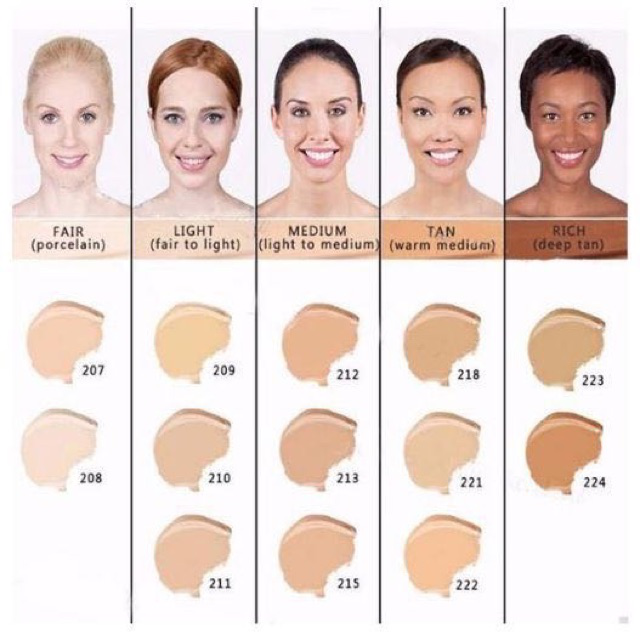

In [15]:
Image.open('../input/sample-ndsc2019/sample/beauty/000232799372575307bede19cdc3c5c8.jpg')

In [16]:
df = pd.read_csv('../input/ndsc-samplescsv/sample_image.csv')

In [17]:
df.head()

,itemid,title,Category,image_path
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg
